# Day-to-day evolution of supply and demand
Module for simulating ridesourcing evolution

Contribution by Arjan de Ruijter - a.j.f.deruijter@tudelft.nl

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim and MaaSSim/MaaSSim to path (not needed if already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from MaaSSim.utils import save_config, get_config, load_G, generate_demand, initialize_df, empty_series, \
    slice_space, test_space
from MaaSSim.maassim import Simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.d2d import *
from MaaSSim.shared import prep_shared_rides

In [3]:
import pandas as pd
import logging
import matplotlib.pyplot as plt

In [4]:
# Load config
params = get_config('../../data/config/delft.json')  # load configuration

In [5]:
# Experiment replications and number of threads to be used
params.parallel.nReplications = 1
params.parallel.nThread = 3

# Main experimental settings
params.nP = 2000 # travellers
params.nV = 20 # drivers
params.nD = 20 # days
params.simTime = 8 # hours

params.demand_structure.destinations_dispertion = -0.0003

In [6]:
# Other day-to-day settings
params.evol.drivers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience
params.evol.drivers.res_wage.mean = 80 #euros
params.evol.drivers.res_wage.std = 20 #euros
params.evol.drivers.init_inc_ratio = 2 #expected income of informed drivers at start of sim as ratio of res wage

params.evol.drivers.inform.prob_start = 1 # probability of being informed at start of sim
params.evol.drivers.inform.beta = 0.2 # information transmission rate

params.evol.drivers.regist.prob_start = 1 # probability of being registered if informed at start of sim
params.evol.drivers.regist.beta = 0.2 # registration choice model parameter
params.evol.drivers.regist.cost_comp = 20 # daily share of registration costs (euros)
params.evol.drivers.regist.samp = 0.2 # probability of making regist decision when informed (and unregistered)

params.evol.drivers.particip.beta = 0.1 # participation choice model parameter
params.evol.drivers.particip.probabilistic = True # stochasticity in participation choice

# params.evol.min_it = 10 # minimum number of days in simulation
# params.evol.conv = 0.005 # convergence criterion, currently not in use

# Financial settings
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = 1.21 #euro/km
params.platforms.min_fare = 0 # euro
params.platforms.comm_rate = 0.25 #rate
params.drivers.fuel_costs = 0.25 #euro/km

# Demand settings
# params.min_dist = 2 # minimum OD distance when creating requests
# params.max_dist = 30 # maximum OD distance

# Start time
params.t0 = pd.Timestamp.now()

In [7]:
inData = load_G(inData, params, stats=True)  # download graph for the 'params.city' and calc the skim matrices
inData = generate_demand(inData, params, avg_speed = True)
fixed_supply = generate_vehicles_d2d(inData, params)
inData.vehicles = fixed_supply.copy()
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = pd.concat([inData.platforms,pd.DataFrame(columns=['base_fare','comm_rate','min_fare'])])
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[params.platforms.fare,'Uber',30,params.platforms.base_fare,params.platforms.comm_rate,params.platforms.min_fare,]

inData = prep_shared_rides(inData, params.shareability)  # prepare schedules

In [8]:
d2d = DotMap()
d2d.drivers = dict()
d2d.travs = dict()
sim = Simulator(inData, params=params,
                    kpi_veh = D2D_veh_exp,
                    f_driver_out = D2D_driver_out,
                    f_trav_mode = pax_mode_choice,
                    logger_level=logging.WARNING)  # initialize

for day in range(params.get('nD', 1)):  # run iterations
    sim.make_and_run(run_id=day)  # prepare and SIM
    sim.output()  # calc results

    d2d.drivers[day] = update_d2d_drivers(sim=sim,params=params)
    d2d.travs[day] = update_d2d_travellers(sim=sim,params=params)
    res_inf = word_of_mouth(inData, params = params)
    inData.vehicles.informed = res_inf
    res_regist = platform_regist(inData, d2d.drivers[day], params = params)
    inData.vehicles.registered = res_regist.registered
    inData.vehicles.expected_income = res_regist.expected_income
    inData.vehicles.pos = fixed_supply.pos

evol_micro, evol_agg = D2D_summary(d2d=d2d) # multi-day stats

27-01-21 19:13:15-WARNING-Setting up 8h simulation at 2021-01-27 15:13:30 for 20 vehicles and 2000 passengers in Delft, Netherlands
27-01-21 19:14:14-WARNING-day 0: simulation time 56.4 s
27-01-21 19:14:16-WARNING-assertion tests for simulation results - passed
27-01-21 19:15:10-WARNING-day 1: simulation time 51.7 s
27-01-21 19:15:12-WARNING-assertion tests for simulation results - passed
27-01-21 19:16:05-WARNING-day 2: simulation time 51.2 s
27-01-21 19:16:07-WARNING-assertion tests for simulation results - passed
27-01-21 19:17:01-WARNING-day 3: simulation time 51.5 s
27-01-21 19:17:03-WARNING-assertion tests for simulation results - passed
27-01-21 19:17:56-WARNING-day 4: simulation time 51.0 s
27-01-21 19:17:58-WARNING-assertion tests for simulation results - passed
27-01-21 19:18:53-WARNING-day 5: simulation time 52.7 s
27-01-21 19:18:55-WARNING-assertion tests for simulation results - passed
27-01-21 19:19:48-WARNING-day 6: simulation time 50.8 s
27-01-21 19:19:50-WARNING-assert

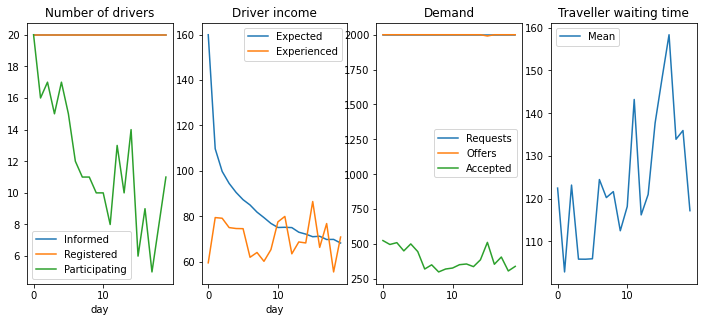

In [21]:
# Plot number of drivers and income
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (12,4.8))
evol_agg.supply[['regist','inform','particip']].plot(ax = axes[0])
axes[0].set_title('Number of drivers')
axes[0].legend(['Informed','Registered','Participating'])
evol_agg.supply[['mean_perc_inc','mean_exp_inc']].plot(ax = axes[1])
axes[1].set_title('Driver income')
axes[1].legend(['Expected','Experienced'])

evol_agg.demand[['requests','gets_offer','accepts_offer']].plot(ax = axes[2])
axes[2].set_title('Demand')
axes[2].legend(['Requests','Offers','Accepted'])
evol_agg.demand[['mean_wait']].plot(ax = axes[3])
axes[3].set_title('Traveller waiting time')
axes[3].legend(['Mean'])

In [10]:
evol_agg.supply

,inform,regist,particip,mean_perc_inc,mean_exp_inc
day,,,,,
0,20,20,20,160.000000,59.468961
1,20,20,16,109.734481,79.405889
2,20,20,17,99.741980,79.109618
3,20,20,15,94.467039,74.995495
4,20,20,17,90.489661,74.581612
5,20,20,15,87.286194,74.517032
6,20,20,12,84.963386,61.906710
7,20,20,11,81.813087,64.020720
8,20,20,11,79.390463,60.126664


In [11]:
sim.requests

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,dist,platform,ride_id,position,sim_schedule
id,,,,,,,,,,,,,,,
1,0,1552650539,44846574,2021-01-27 15:13:30,NaN,0 days 00:03:20,2021-01-27 15:16:50,NaN,False,NaN,2004,0,0,0,node time req_id od 0 ...
2,1,44883812,4846026440,2021-01-27 15:13:31,NaN,0 days 00:01:57,2021-01-27 15:15:28,NaN,False,NaN,1173,0,1,0,node time req_id od 0 ...
3,2,44810830,44856860,2021-01-27 15:13:31,NaN,0 days 00:04:49,2021-01-27 15:18:20,NaN,False,NaN,2890,0,2,0,node time req_id od 0 NaN...
4,3,44871804,44864083,2021-01-27 15:13:52,NaN,0 days 00:01:29,2021-01-27 15:15:21,NaN,False,NaN,897,0,3,0,node time req_id od 0 NaN...
5,4,44776713,1402613343,2021-01-27 15:13:59,NaN,0 days 00:11:30,2021-01-27 15:25:29,NaN,False,NaN,6902,0,4,0,node time req_id od 0 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1995,1530303653,260125198,2021-01-27 23:12:22,NaN,0 days 00:04:53,2021-01-27 23:17:15,NaN,False,NaN,2939,0,1995,0,node time req_id od 0 ...
1997,1996,1570983116,260123525,2021-01-27 23:12:31,NaN,0 days 00:04:52,2021-01-27 23:17:23,NaN,False,NaN,2923,0,1996,0,node time req_id od 0 ...
1998,1997,44825829,44853267,2021-01-27 23:13:02,NaN,0 days 00:05:28,2021-01-27 23:18:30,NaN,False,NaN,3283,0,1997,0,node time req_id od 0 NaN...


In [12]:
inData.vehicles

,pos,event,shift_start,shift_end,platform,expected_income,res_wage,informed,registered
veh,,,,,,,,,
1,44847501,driverEvent.ENDS_SHIFT,0,86400,0,76.472201,46.567528,True,True
2,1510592123,driverEvent.ENDS_SHIFT,0,86400,0,78.734994,76.988002,True,True
3,5124546092,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,60.023548,81.247789,True,True
4,44858421,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,73.993038,113.422556,True,True
5,3452839332,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,60.719887,74.945238,True,True
6,1851699238,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,67.926811,86.935430,True,True
7,44838049,driverEvent.ENDS_SHIFT,0,86400,0,56.337852,72.884229,True,True
8,4300794721,driverEvent.ENDS_SHIFT,0,86400,0,74.341274,75.041777,True,True
9,1391417166,driverEvent.ENDS_SHIFT,0,86400,0,88.102942,62.934137,True,True


In [13]:
d2d.travs[0]

,orig,dest,t_req,tt_min,dist,informed,no_request,other_mode,no_offer,xp_wait,xp_ivt,xp_ops,xp_tt_total,exp_tt_wait_prev
pax,,,,,,,,,,,,,,
1,1552650539,44846574,2021-01-27 15:13:30,0 days 00:03:20,2004,True,False,True,False,NaN,NaN,NaN,NaN,0
2,44883812,4846026440,2021-01-27 15:13:31,0 days 00:01:57,1173,True,False,True,False,NaN,NaN,NaN,NaN,0
3,44810830,44856860,2021-01-27 15:13:31,0 days 00:04:49,2890,True,False,True,False,NaN,NaN,NaN,NaN,0
4,44871804,44864083,2021-01-27 15:13:52,0 days 00:01:29,897,True,False,True,False,NaN,NaN,NaN,NaN,0
5,44776713,1402613343,2021-01-27 15:13:59,0 days 00:11:30,6902,True,False,False,False,126.0,690.0,55.0,871.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,1530303653,260125198,2021-01-27 23:12:22,0 days 00:04:53,2939,True,False,True,False,NaN,NaN,NaN,NaN,0
1997,1570983116,260123525,2021-01-27 23:12:31,0 days 00:04:52,2923,True,False,True,False,NaN,NaN,NaN,NaN,0
1998,44825829,44853267,2021-01-27 23:13:02,0 days 00:05:28,3283,True,False,False,False,5.0,328.0,55.0,388.0,0


In [14]:
sim.res[0].pax_exp

,ACCEPTS_OFFER,ARRIVES_AT_DROPOFF,ARRIVES_AT_PICKUP,DEPARTS_FROM_PICKUP,MEETS_DRIVER_AT_PICKUP,RECEIVES_OFFER,REJECTS_OFFER,REQUESTS_RIDE,SETS_OFF_FOR_DEST,STARTS_DAY,IS_REJECTED_BY_VEHICLE,ARRIVES_AT_DEST,PREFERS_OTHER_SERVICE,LOSES_PATIENCE,TRAVEL,WAIT,OPERATIONS
pax,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,15.0,1.0,0.0,0,0,0,0,0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,15.0,1.0,0.0,0,0,0,0,0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,15.0,22.0,0.0,0,0,0,0,0,0.0,0.0,0.0
4,15.0,690.0,20.0,30.0,126.0,0.0,0.0,29.0,10.0,0,0,0,0,0,690.0,126.0,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,15.0,28732.0,0.0,0,0,0,0,0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,15.0,28741.0,0.0,0,0,0,0,0,0.0,0.0,0.0
1997,15.0,328.0,20.0,30.0,5.0,0.0,0.0,28772.0,10.0,0,0,0,0,0,328.0,5.0,55.0


In [15]:
sim.res[1].veh_exp

,nRIDES,nREJECTED,DRIVING_TIME,DRIVING_DIST,REVENUE,COST,NET_INCOME,OUT,STARTS_DAY,OPENS_APP,...,IS_REJECTED_BY_TRAVELLER,ARRIVES_AT_PICKUP,MEETS_TRAVELLER_AT_PICKUP,DEPARTS_FROM_PICKUP,ARRIVES_AT_DROPOFF,CONTINUES_SHIFT,STARTS_REPOSITIONING,REPOSITIONED,DECIDES_NOT_TO_DRIVE,ENDS_SHIFT
veh,,,,,,,,,,,,,,,,,,,,,
1,29.0,91.0,22447.0,224.47,143.252250,56.1175,87.134750,False,0,0.0,...,6805.0,0.0,870.0,12430.0,10284.0,0,0,0,0,0
2,32.0,137.0,22743.0,227.43,143.362125,56.8575,86.504625,False,0,35.0,...,8381.0,34.0,960.0,12095.0,9078.0,0,0,0,0,0
3,29.0,59.0,28010.0,280.10,138.061350,70.0250,68.036350,False,0,1.0,...,13993.0,8.0,870.0,11858.0,5215.0,0,0,0,0,0
4,0.0,0.0,0.0,0.00,0.000000,0.0000,0.000000,True,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
5,39.0,72.0,22272.0,222.72,182.910225,55.6800,127.230225,False,0,29.0,...,3234.0,26.0,1170.0,15643.0,10063.0,0,0,0,0,0
6,0.0,0.0,0.0,0.00,0.000000,0.0000,0.000000,True,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
7,31.0,86.0,28240.0,282.40,144.526425,70.6000,73.926425,False,0,110.0,...,13451.0,13.0,930.0,12339.0,4303.0,0,0,0,0,0
8,35.0,98.0,22203.0,222.03,164.453400,55.5075,108.945900,False,0,304.0,...,4885.0,24.0,1050.0,14072.0,9747.0,0,0,0,0,0
9,17.0,78.0,25644.0,256.44,73.525125,64.1100,9.415125,False,0,50.0,...,18666.0,30.0,510.0,6135.0,7994.0,0,0,0,0,0


In [16]:
sim.runs[0].trips

,pax,pos,t,event,veh_id
0,0,1552650539,0,STARTS_DAY,NaN
1,0,1552650539,0,REQUESTS_RIDE,NaN
2,0,1552650539,0,RECEIVES_OFFER,NaN
3,0,1552650539,15,REJECTS_OFFER,NaN
0,1,44883812,0,STARTS_DAY,NaN
...,...,...,...,...,...
3,1998,44821027,28787,REJECTS_OFFER,NaN
0,1999,628841466,0,STARTS_DAY,NaN
1,1999,628841466,28773,REQUESTS_RIDE,NaN
2,1999,628841466,28773,RECEIVES_OFFER,NaN


In [17]:
sim.inData.passengers

,pos,event,platforms
pax,,,
0,1552650539,NaN,[0]
1,44883812,NaN,[0]
2,44810830,NaN,[0]
3,44871804,NaN,[0]
4,44776713,NaN,[0]
...,...,...,...
1995,1530303653,NaN,[0]
1996,1570983116,NaN,[0]
1997,44825829,NaN,[0]


In [18]:
sim.vehicles

,pos,event,shift_start,shift_end,platform,expected_income,res_wage,informed,registered
veh,,,,,,,,,
1,44847501,driverEvent.ENDS_SHIFT,0,86400,0,76.472201,46.567528,True,True
2,1510592123,driverEvent.ENDS_SHIFT,0,86400,0,78.734994,76.988002,True,True
3,5124546092,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,60.023548,81.247789,True,True
4,44858421,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,73.993038,113.422556,True,True
5,3452839332,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,60.719887,74.945238,True,True
6,1851699238,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,67.926811,86.935430,True,True
7,44838049,driverEvent.ENDS_SHIFT,0,86400,0,56.337852,72.884229,True,True
8,4300794721,driverEvent.ENDS_SHIFT,0,86400,0,74.341274,75.041777,True,True
9,1391417166,driverEvent.ENDS_SHIFT,0,86400,0,88.102942,62.934137,True,True


In [19]:
params

DotMap(NAME='default', city='Delft, Netherlands', nP=2000, nV=20, times=DotMap(request=15, transaction=20, pickup=30, dropoff=10, patience=600, pickup_patience=90), speeds=DotMap(walk=1.2, ride=10), t0=Timestamp('2021-01-27 19:13:09'), paths=DotMap(main='/Users/rkucharski/Documents/GitHub/MaaSSim', data='/Users/rkucharski/Documents/GitHub/MaaSSim/data', params='/Users/rkucharski/Documents/GitHub/MaaSSim/data/configs', G='../../data/graphs/Delft.graphml', skim='../../data/graphs/Delft.csv', _ipython_display_=DotMap(), _repr_mimebundle_=DotMap(), _repr_html_=DotMap(), _repr_markdown_=DotMap(), _repr_svg_=DotMap(), _repr_png_=DotMap(), _repr_pdf_=DotMap(), _repr_jpeg_=DotMap(), _repr_latex_=DotMap(), _repr_json_=DotMap(), _repr_javascript_=DotMap()), dist_threshold=100000, big_time=10, sleep=False, simTime=8, demand_structure=DotMap(origins_dispertion=-0.0003, destinations_dispertion=-0.0003, temporal_dispertion=0.3, temporal_distribution='uniform'), shareability=DotMap(windows=DotMap(pic

In [20]:
d2d.drivers[0]

,pos,informed,registered,out,init_perc_inc,exp_inc,new_perc_inc,worked_days
veh,,,,,,,,
1,4.486033e+07,True,True,False,160.0,75.985450,117.992725,1
2,1.402599e+09,True,True,False,160.0,81.522025,120.761012,1
3,1.519890e+09,True,True,False,160.0,103.039275,131.519637,1
4,1.432079e+09,True,True,False,160.0,29.577450,94.788725,1
5,1.402735e+09,True,True,False,160.0,73.190025,116.595012,1
6,4.485327e+07,True,True,False,160.0,0.516225,80.258112,1
7,1.402599e+09,True,True,False,160.0,18.047700,89.023850,1
8,4.483319e+07,True,True,False,160.0,110.051050,135.025525,1
9,4.489246e+07,True,True,False,160.0,100.614875,130.307437,1
